In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
import copy
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr
from numcodecs.abc import Codec

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5_U = ERA5["u"].sel(valid_time="2024-04-02T12:00:00")
ERA5_U.shape

(1, 721, 1440)

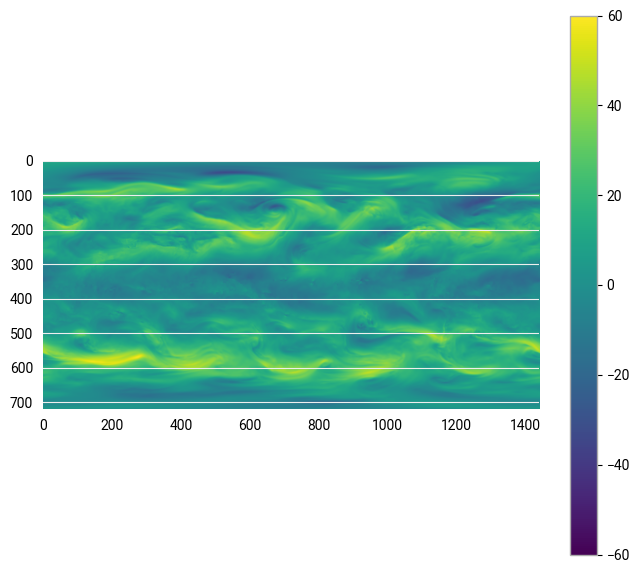

In [4]:
from matplotlib import pyplot as plt

plt.imshow(np.squeeze(ERA5_U.values), vmin=-60, vmax=60)
plt.colorbar()
plt.show()

In [5]:
from compression_safeguards import Safeguards, SafeguardKind
from numcodecs_safeguards.lossless import Lossless

In [6]:
qoi = SafeguardKind.qoi_eb_stencil.value(
    qoi="finite_difference(x, order=2, accuracy=4, type=0, axis=0, grid_spacing=1)",
    neighbourhood=[
        dict(axis=1, before=2, after=2, boundary="wrap"),
    ],
    type="abs",
    eb=0.1,
)
qoi._qoi_expr

(X[2] * (5 / -2) + X[3] * (4 / 3) + X[1] * (4 / 3) + X[4] * (1 / -12) + X[0] * (-1 / 12))

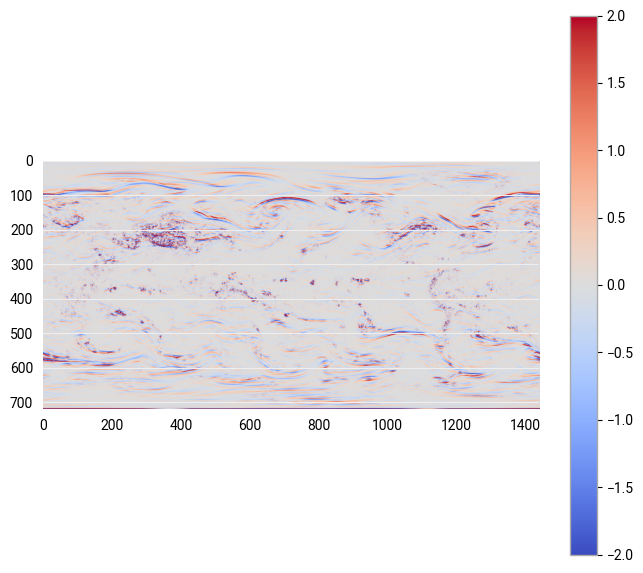

In [7]:
from matplotlib import pyplot as plt

from compression_safeguards.utils.bindings import Bindings

plt.imshow(
    np.squeeze(qoi.evaluate_qoi(ERA5_U.values, late_bound=Bindings.empty())),
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
)
plt.colorbar()
plt.show()

In [8]:
sg = Safeguards(safeguards=[qoi])

In [9]:
correction_codec = Lossless().for_safeguards
correction_codec

CodecStack(PickBestCodec(HuffmanCodec(), CodecStack(BinaryDeltaCodec(), HuffmanCodec())), Zstd(level=3))

In [10]:
ERA5_U_prediction = np.zeros_like(ERA5_U.values)

In [11]:
ERA5_U_sg_correction = sg.compute_correction(ERA5_U.values, ERA5_U_prediction)
ERA5_U_sg = sg.apply_correction(ERA5_U_prediction, ERA5_U_sg_correction)

assert sg.check(ERA5_U.values, ERA5_U_sg)

In [12]:
ERA5_U_sg_encoded = correction_codec.encode(ERA5_U_sg_correction)
print(ERA5_U.nbytes / np.array(ERA5_U_sg_encoded).nbytes)

4.968089318804154


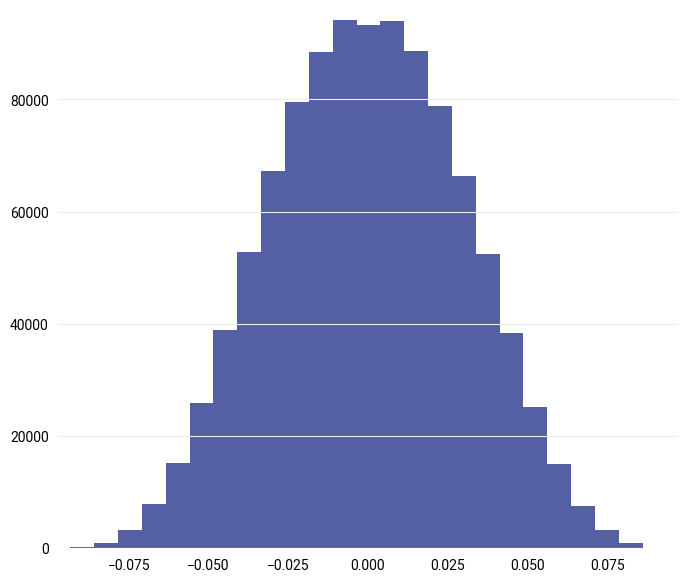

In [13]:
from matplotlib import pyplot as plt

from compression_safeguards.utils.bindings import Bindings

plt.hist(
    (
        qoi.evaluate_qoi(ERA5_U_sg, late_bound=Bindings.empty())
        - qoi.evaluate_qoi(ERA5_U.values, late_bound=Bindings.empty())
    ).flatten(),
    bins=25,
)
plt.show()

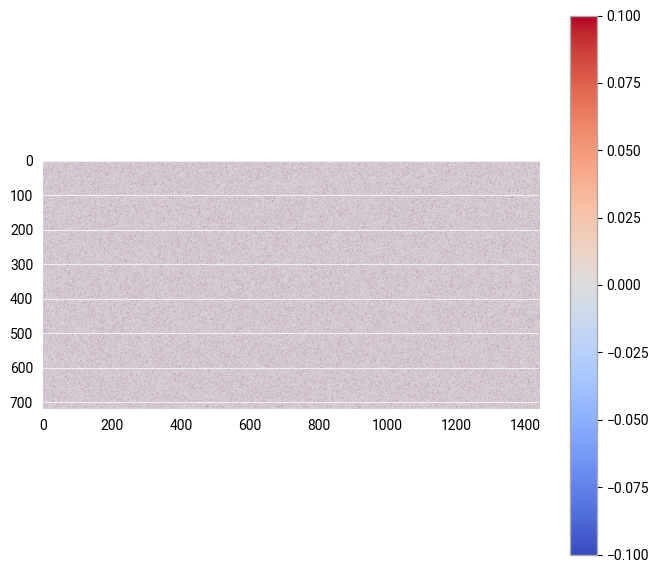

In [14]:
from matplotlib import pyplot as plt

plt.imshow(
    np.squeeze(
        qoi.evaluate_qoi(ERA5_U_sg, late_bound=Bindings.empty())
        - qoi.evaluate_qoi(ERA5_U.values, late_bound=Bindings.empty())
    ),
    cmap="coolwarm",
    vmin=-0.1,
    vmax=0.1,
)
plt.colorbar()
plt.show()

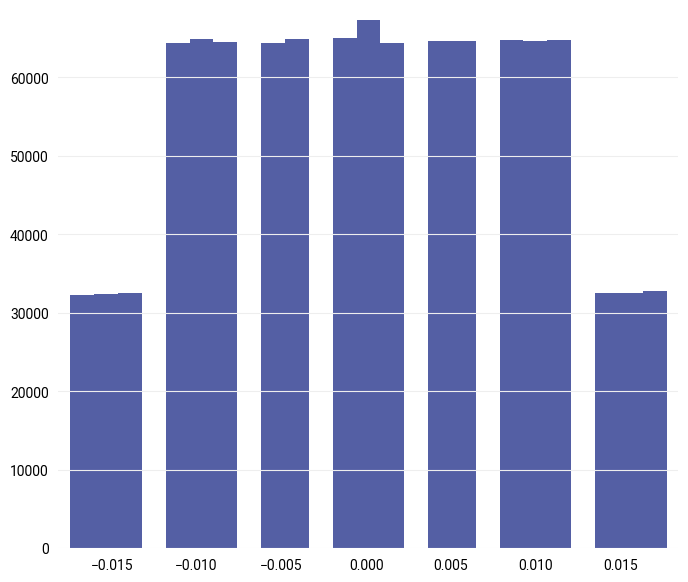

In [15]:
from matplotlib import pyplot as plt

plt.hist((ERA5_U_sg - ERA5_U.values).flatten(), bins=25)
plt.show()

In [16]:
from collections.abc import Set
from typing import ClassVar
from typing_extensions import override

from compression_safeguards.safeguards.pointwise.abc import PointwiseSafeguard
from compression_safeguards.utils.bindings import Bindings, Parameter
from compression_safeguards.utils.typing import JSON, S, T
from compression_safeguards.utils.intervals import Interval, IntervalUnion, Lower, Upper


class ProgressiveSafeguard(PointwiseSafeguard):
    __slots__: tuple[str, ...] = ()

    kind: ClassVar[str] = "progressive"

    def __init__(self) -> None:
        pass

    @property
    @override
    def late_bound(self) -> Set[Parameter]:
        return frozenset([Parameter("$progmask"), Parameter("$progdone")])

    @override
    def check_pointwise(
        self,
        data: np.ndarray[S, np.dtype[T]],
        decoded: np.ndarray[S, np.dtype[T]],
        *,
        late_bound: Bindings,
    ) -> np.ndarray[S, np.dtype[np.bool]]:
        return np.ones_like(data, dtype=np.bool)  # type: ignore

    @override
    def compute_safe_intervals(
        self,
        data: np.ndarray[S, np.dtype[T]],
        *,
        late_bound: Bindings,
    ) -> IntervalUnion[T, int, int]:
        mask = late_bound.resolve_ndarray_with_lossless_cast(
            Parameter("$progmask"), data.shape, np.dtype(np.bool)
        )
        done = late_bound.resolve_ndarray_with_lossless_cast(
            Parameter("$progdone"), data.shape, data.dtype
        )

        valid = Interval.full_like(data)
        Lower(done.flatten()) <= valid[mask.flatten()] <= Upper(done.flatten())

        validu = valid.into_union()

        class MyIntervalUnion(IntervalUnion):
            __slots__ = ()

            def contains(
                self, other: np.ndarray[S, np.dtype[T]]
            ) -> np.ndarray[S, np.dtype[np.bool]]:
                if np.array_equal(other, data, equal_nan=True):
                    return np.ones(other.shape, dtype=np.bool)
                return super().contains(other)

        validu.__class__ = MyIntervalUnion

        return validu

    @override
    def get_config(self) -> dict[str, JSON]:
        return dict(kind=type(self).kind)

In [17]:
import re

qoi_progressive_expr = SafeguardKind.qoi_eb_stencil.value(
    qoi=re.sub(
        r"X\[([^]]+)\]",
        r'where(C["$progmask"][\1], C["$progdone"][\1], X[\1])',
        repr(qoi._qoi_expr),
    ),
    **{k: v for k, v in qoi.get_config().items() if k not in ("kind", "qoi")},
)._qoi_expr
qoi_progressive_expr

(where(C["$progmask"][2], C["$progdone"][2], X[2]) * (5 / -2) + where(C["$progmask"][3], C["$progdone"][3], X[3]) * (4 / 3) + where(C["$progmask"][1], C["$progdone"][1], X[1]) * (4 / 3) + where(C["$progmask"][4], C["$progdone"][4], X[4]) * (1 / -12) + where(C["$progmask"][0], C["$progdone"][0], X[0]) * (-1 / 12))

In [18]:
from collections.abc import Mapping

from compression_safeguards.safeguards._qois import StencilQuantityOfInterest
from compression_safeguards.safeguards._qois.expr.typing import Ps, Ns, F


class MyStencilQuantityOfInterest(StencilQuantityOfInterest):
    __slots__ = ()

    @property
    def late_bound_constants(self) -> Set[Parameter]:
        return qoi_progressive_expr.late_bound_constants

    @np.errstate(divide="ignore", over="ignore", under="ignore", invalid="ignore")
    def compute_data_bounds(
        self,
        qoi_lower: np.ndarray[Ps, np.dtype[F]],
        qoi_upper: np.ndarray[Ps, np.dtype[F]],
        Xs: np.ndarray[Ns, np.dtype[F]],
        late_bound: Mapping[Parameter, np.ndarray[Ns, np.dtype[F]]],
    ) -> tuple[np.ndarray[Ns, np.dtype[F]], np.ndarray[Ns, np.dtype[F]]]:
        return qoi_progressive_expr.compute_data_bounds(
            qoi_lower, qoi_upper, Xs, late_bound
        )

In [19]:
qoi_progressive = SafeguardKind.qoi_eb_stencil.value(
    **{k: v for k, v in qoi.get_config().items() if k not in ("kind",)}
)
qoi_progressive._qoi_expr.__class__ = MyStencilQuantityOfInterest

sg_progressive = Safeguards(
    safeguards=[
        ProgressiveSafeguard(),
        qoi_progressive,
    ]
)

In [20]:
qoi_stencil = []

for axis in qoi.compute_check_neighbourhood_for_data_shape(ERA5_U.shape):
    max_stencil = 1

    for b, s in axis.items():
        max_stencil = max(max_stencil, s.before + 1 + s.after)

    qoi_stencil.append(max_stencil)

qoi_stencil

[1, 5, 1]

In [21]:
from itertools import product

ERA5_U_sg_progmask = np.zeros(ERA5_U.shape, dtype=np.bool)
ERA5_U_sg_progcorr = np.empty(
    ERA5_U.values.shape, sg.correction_dtype_for_data(ERA5_U.dtype)
)
ERA5_U_sg_progdone = np.empty_like(ERA5_U.values)

for i in product(*[range(s) for s in qoi_stencil]):
    progindex = tuple(
        slice(None) if s == 1 else slice(j, None, s) for j, s in zip(i, qoi_stencil)
    )
    print(progindex)

    ERA5_U_sg_progressive_correction = sg_progressive.compute_correction(
        ERA5_U.values,
        ERA5_U_prediction,
        late_bound={"$progmask": ERA5_U_sg_progmask, "$progdone": ERA5_U_sg_progdone},
    )
    ERA5_U_sg_progressive_corrected = sg_progressive.apply_correction(
        ERA5_U_prediction, ERA5_U_sg_progressive_correction
    )

    ERA5_U_sg_progcorr[progindex] = ERA5_U_sg_progressive_correction[progindex]
    ERA5_U_sg_progdone[progindex] = ERA5_U_sg_progressive_corrected[progindex]
    ERA5_U_sg_progmask[progindex] = True

ERA5_U_sg_progressive_correction = np.copy(ERA5_U_sg_progcorr)
ERA5_U_sg_progressive = sg.apply_correction(
    ERA5_U_prediction, ERA5_U_sg_progressive_correction
)

assert sg.check(ERA5_U.values, ERA5_U_sg_progressive)

(slice(None, None, None), slice(0, None, 5), slice(None, None, None))
(slice(None, None, None), slice(1, None, 5), slice(None, None, None))
(slice(None, None, None), slice(2, None, 5), slice(None, None, None))
(slice(None, None, None), slice(3, None, 5), slice(None, None, None))
(slice(None, None, None), slice(4, None, 5), slice(None, None, None))


In [22]:
ERA5_U_sg_progressive_encoded = correction_codec.encode(
    ERA5_U_sg_progressive_correction
)
print(ERA5_U.nbytes / np.array(ERA5_U_sg_progressive_encoded).nbytes)

3.3456429690067866


In [23]:
ERA5_U_sg_progressive_nbytes = 0

for i in product(*[range(s) for s in qoi_stencil]):
    progindex = tuple(
        slice(None) if s == 1 else slice(j, None, s) for j, s in zip(i, qoi_stencil)
    )

    ERA5_U_sg_progressive_nbytes += np.array(
        correction_codec.encode(
            np.ascontiguousarray(ERA5_U_sg_progressive_correction[progindex])
        ),
        copy=None,
    ).nbytes

print(ERA5_U.nbytes / ERA5_U_sg_progressive_nbytes)

3.1471044919987907


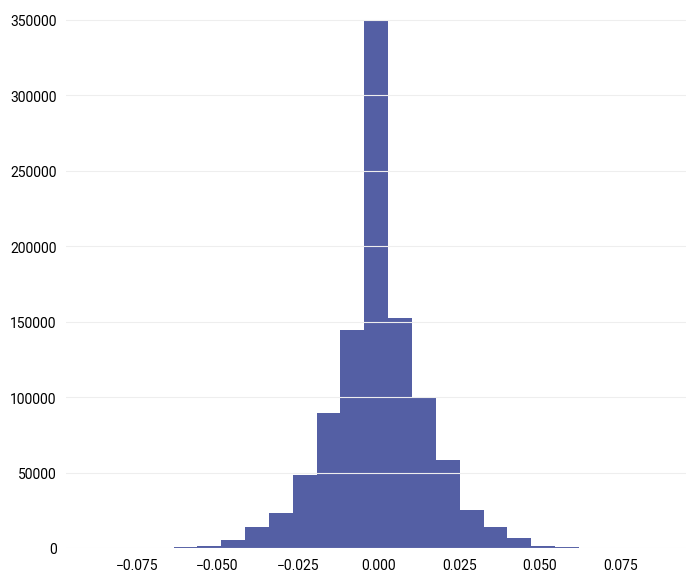

In [24]:
from matplotlib import pyplot as plt

from compression_safeguards.utils.bindings import Bindings

plt.hist(
    (
        qoi.evaluate_qoi(ERA5_U_sg_progressive, late_bound=Bindings.empty())
        - qoi.evaluate_qoi(ERA5_U.values, late_bound=Bindings.empty())
    ).flatten(),
    bins=25,
)
plt.show()

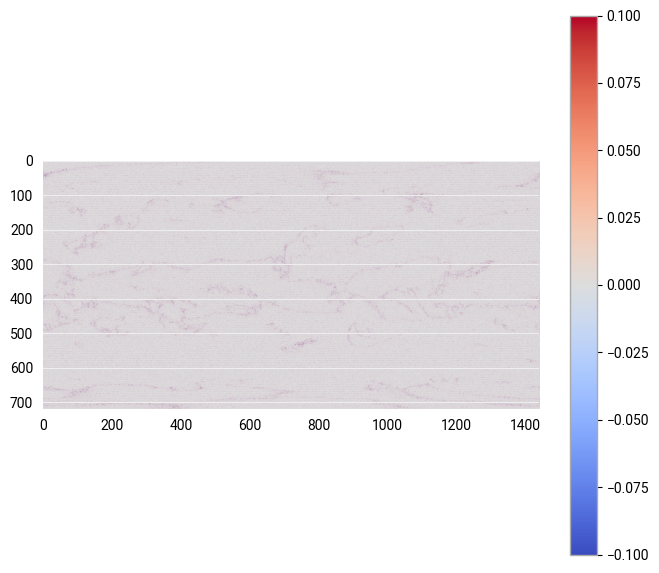

In [25]:
from matplotlib import pyplot as plt

plt.imshow(
    np.squeeze(
        qoi.evaluate_qoi(ERA5_U_sg_progressive, late_bound=Bindings.empty())
        - qoi.evaluate_qoi(ERA5_U.values, late_bound=Bindings.empty())
    ),
    cmap="coolwarm",
    vmin=-0.1,
    vmax=0.1,
)
plt.colorbar()
plt.show()

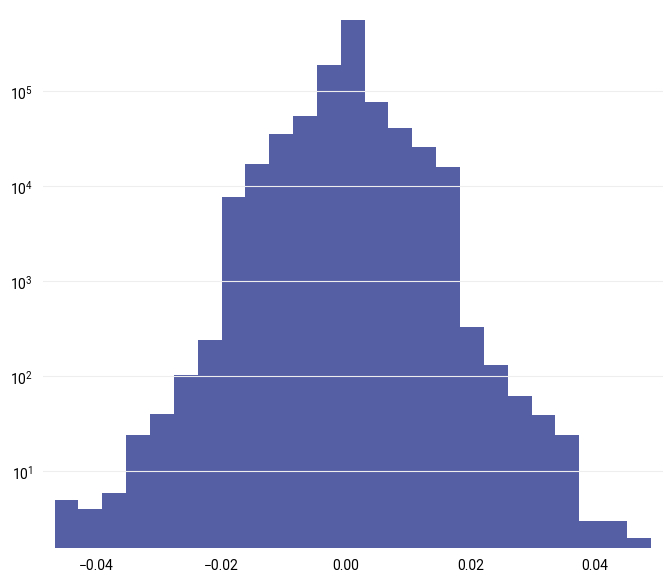

In [26]:
from matplotlib import pyplot as plt

plt.hist((ERA5_U_sg_progressive - ERA5_U.values).flatten(), bins=25, log=True)
plt.show()